# NYCFHV Demo

This is an example of how to use the Synthetic Data tool.

First, we perform synthetic data generation on the NYCFHV dataset.

In [1]:
import os
from pathlib import Path

In [2]:
os.environ["TESTING"] = "true"
os.environ["SYNTHEFY_PACKAGE_BASE"] = "/home/ubuntu/code/synthefy-package"

In [3]:
BASE_URL = "http://127.0.0.1:8000"
SYNTHEFY_PACKAGE_BASE = Path(os.getenv("SYNTHEFY_PACKAGE_BASE"))

SYNTHEFY_PACKAGE_BASE

PosixPath('/home/ubuntu/code/synthefy-package')

In [4]:
SYNTHEFY_DATASETS_BASE = Path(os.getenv("SYNTHEFY_DATASETS_BASE", "/home/ubuntu/data"))

In [5]:
time_series_length = 120
forecast_length = 60
time_series_length = 48
forecast_length = 12

In [6]:
import json

import httpx
import matplotlib.pyplot as plt
import pandas as pd

from synthefy_pkg.app.data_models import DynamicTimeSeriesData

/home/ubuntu/code/synthefy-package/synthefy_dev/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in TrainSynthesisRequest has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


Setup Client

In [7]:
client = httpx.Client(base_url=BASE_URL, timeout=30.0)

Setup your input data for Forecasting

For Forecasting, both the meta-data conditions and the time-series data need to be passed in.

For reference, the time-series cols are as follows:

In [8]:
time_series_cols = ["ride_count",]
time_series_col = time_series_cols[0]

The meta-data cols are divided into two categories: discrete and continuous.

Discrete:

In [9]:
discrete_cols = ["gas_price",]

Continuous:

In [10]:
continuous_cols = []

There are also group_labels, which can be thought of as 'artificial' discrete conditions

In [11]:
group_labels = []

The timestamp column in the raw data is also defined

In [12]:
timestamps_col = ["date_hour",]

In my case, I'm going to get data from a csv I have handy.

In [13]:
df = pd.read_csv(SYNTHEFY_DATASETS_BASE / Path("nycfhv") / Path("nycfhv_data_window_metadata_only.csv"))
df = df.drop(columns=["Unnamed: 0",])
df

,date,hour,date_hour,gas_price,tmpf
0,2019-02-01,0,2019-02-01 00:00:00,2.358,14.0
1,2019-02-01,1,2019-02-01 01:00:00,2.358,14.0
2,2019-02-01,2,2019-02-01 02:00:00,2.358,14.0
3,2019-02-01,3,2019-02-01 03:00:00,2.358,14.0
4,2019-02-01,4,2019-02-01 04:00:00,2.358,14.0
...,...,...,...,...,...
115,2019-02-05,19,2019-02-05 19:00:00,2.337,63.0
116,2019-02-05,20,2019-02-05 20:00:00,2.337,64.0
117,2019-02-05,21,2019-02-05 21:00:00,2.337,65.0
118,2019-02-05,22,2019-02-05 22:00:00,2.337,64.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       120 non-null    object 
 1   hour       120 non-null    int64  
 2   date_hour  120 non-null    object 
 3   gas_price  120 non-null    float64
 4   tmpf       120 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.8+ KB


You can also setup your own df and populate it

In [15]:
df_dtypes = df.dtypes

In [16]:
empty_df = pd.DataFrame({col: pd.Series(dtype=dt) for col, dt in df_dtypes.items()})
empty_df

,date,hour,date_hour,gas_price,tmpf


In [17]:
empty_df["date"] = pd.to_datetime("2022-01-01")
empty_df["hour"] = 2
empty_df["date_hour"] = pd.to_datetime("2022-01-01_00", format="%Y-%m-%d_%H")
empty_df["gas_price"] = 3.36

Convert the df to a json

In [18]:
columns_to_check = ["gas_price",]
null_counts = df[columns_to_check].isnull().sum()
null_counts

gas_price    0
dtype: int64

In [19]:
# Fill Null Values
df = df.fillna(method='ffill')

In [20]:
# make just one window
df = df[:time_series_length]

In [21]:
json_data_for_stream = df.to_json()
json_data_for_stream

'{"date":{"0":"2019-02-01","1":"2019-02-01","2":"2019-02-01","3":"2019-02-01","4":"2019-02-01","5":"2019-02-01","6":"2019-02-01","7":"2019-02-01","8":"2019-02-01","9":"2019-02-01","10":"2019-02-01","11":"2019-02-01","12":"2019-02-01","13":"2019-02-01","14":"2019-02-01","15":"2019-02-01","16":"2019-02-01","17":"2019-02-01","18":"2019-02-01","19":"2019-02-01","20":"2019-02-01","21":"2019-02-01","22":"2019-02-01","23":"2019-02-01","24":"2019-02-02","25":"2019-02-02","26":"2019-02-02","27":"2019-02-02","28":"2019-02-02","29":"2019-02-02","30":"2019-02-02","31":"2019-02-02","32":"2019-02-02","33":"2019-02-02","34":"2019-02-02","35":"2019-02-02","36":"2019-02-02","37":"2019-02-02","38":"2019-02-02","39":"2019-02-02","40":"2019-02-02","41":"2019-02-02","42":"2019-02-02","43":"2019-02-02","44":"2019-02-02","45":"2019-02-02","46":"2019-02-02","47":"2019-02-02"},"hour":{"0":0,"1":1,"2":2,"3":3,"4":4,"5":5,"6":6,"7":7,"8":8,"9":9,"10":10,"11":11,"12":12,"13":13,"14":14,"15":15,"16":16,"17":17,"18

In [22]:
# Check for validity
DynamicTimeSeriesData(root=json.loads(json_data_for_stream))

DynamicTimeSeriesData(root={'date': {'0': '2019-02-01', '1': '2019-02-01', '2': '2019-02-01', '3': '2019-02-01', '4': '2019-02-01', '5': '2019-02-01', '6': '2019-02-01', '7': '2019-02-01', '8': '2019-02-01', '9': '2019-02-01', '10': '2019-02-01', '11': '2019-02-01', '12': '2019-02-01', '13': '2019-02-01', '14': '2019-02-01', '15': '2019-02-01', '16': '2019-02-01', '17': '2019-02-01', '18': '2019-02-01', '19': '2019-02-01', '20': '2019-02-01', '21': '2019-02-01', '22': '2019-02-01', '23': '2019-02-01', '24': '2019-02-02', '25': '2019-02-02', '26': '2019-02-02', '27': '2019-02-02', '28': '2019-02-02', '29': '2019-02-02', '30': '2019-02-02', '31': '2019-02-02', '32': '2019-02-02', '33': '2019-02-02', '34': '2019-02-02', '35': '2019-02-02', '36': '2019-02-02', '37': '2019-02-02', '38': '2019-02-02', '39': '2019-02-02', '40': '2019-02-02', '41': '2019-02-02', '42': '2019-02-02', '43': '2019-02-02', '44': '2019-02-02', '45': '2019-02-02', '46': '2019-02-02', '47': '2019-02-02'}, 'hour': {'0'

Now query the API

In [23]:
stream_synthesis_response = client.post(
    "/api/synthesis/nycfhv/stream", json=json.loads(json_data_for_stream)
)

Examine the response

In [24]:
if stream_synthesis_response.status_code != 200:
    print(f"Error: {stream_synthesis_response.text}")
else:
    print(f"Success: Code={stream_synthesis_response.status_code}\n")

Success: Code=200



We now have a response object.

In [25]:
dynamic_time_series_data = DynamicTimeSeriesData(
    **stream_synthesis_response.json()
)
dynamic_time_series_data

DynamicTimeSeriesData(root={'ride_count_synthetic': {'0': 10467.935546875, '1': 12441.4931640625, '2': 12128.64453125, '3': 5235.11083984375, '4': 1742.4600830078125, '5': 2404.57080078125, '6': 13622.9921875, '7': 14154.3701171875, '8': 16799.04296875, '9': 16647.3203125, '10': 15654.4541015625, '11': 11118.6884765625, '12': 10496.32421875, '13': 8244.2353515625, '14': 5078.06884765625, '15': 6454.63818359375, '16': 7930.35009765625, '17': 4073.5693359375, '18': 2030.12109375, '19': 9011.923828125, '20': 20565.083984375, '21': 20914.349609375, '22': 18815.728515625, '23': 15642.05859375, '24': 8748.306640625, '25': 6573.701171875, '26': 788.5849609375, '27': 969.9635620117188, '28': 568.0211181640625, '29': 5860.80224609375, '30': 14370.951171875, '31': 23237.33984375, '32': 25275.109375, '33': 19687.52734375, '34': 19737.9296875, '35': 21412.455078125, '36': 17343.955078125, '37': 13965.740234375, '38': 9606.3447265625, '39': 8284.5068359375, '40': 9827.4619140625, '41': 11472.525390

Let's try it again, this time by changing the gas price in the data to be much higher

In [26]:
df['gas_price'] = 4.11

Make the Query

In [27]:
stream_synthesis_response = client.post(
    "/api/synthesis/nycfhv/stream", json=json.loads(df.to_json())
)
if stream_synthesis_response.status_code != 200:
    print(f"Error: {stream_synthesis_response.text}")
else:
    print(f"Success: Code={stream_synthesis_response.status_code}\n")

Success: Code=200



In [28]:
dynamic_time_series_data = DynamicTimeSeriesData(
    **stream_synthesis_response.json()
)
dynamic_time_series_data

DynamicTimeSeriesData(root={'ride_count_synthetic': {'0': 10413.9541015625, '1': 12745.76953125, '2': 12518.6435546875, '3': 5805.70849609375, '4': 2299.975830078125, '5': 2650.96533203125, '6': 13124.681640625, '7': 13680.646484375, '8': 15888.5341796875, '9': 15653.7314453125, '10': 14642.8974609375, '11': 10076.962890625, '12': 9327.0556640625, '13': 6925.015625, '14': 3518.525634765625, '15': 4654.88427734375, '16': 5921.19580078125, '17': 2309.9169921875, '18': 207.38478088378906, '19': 7133.544921875, '20': 18524.244140625, '21': 19094.060546875, '22': 17116.380859375, '23': 13898.166015625, '24': 6473.16357421875, '25': 3919.1689453125, '26': -2677.7255859375, '27': -3414.831298828125, '28': -3874.78369140625, '29': 2147.43115234375, '30': 11620.109375, '31': 21333.095703125, '32': 23841.00390625, '33': 19111.607421875, '34': 19438.212890625, '35': 21065.30859375, '36': 17016.0078125, '37': 13501.83984375, '38': 9218.380859375, '39': 7749.0078125, '40': 9294.7158203125, '41': 10

Visualize the results; only the time-series columns are returned

In [29]:
df = pd.read_json(json.dumps(stream_synthesis_response.json()))
df.info(); df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ride_count_synthetic  48 non-null     float64
 1   date_hour             48 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


,ride_count_synthetic,date_hour
0,10413.954102,2019-02-01T00:00:00
1,12745.769531,2019-02-01T01:00:00
2,12518.643555,2019-02-01T02:00:00
3,5805.708496,2019-02-01T03:00:00
4,2299.975830,2019-02-01T04:00:00
5,2650.965332,2019-02-01T05:00:00
6,13124.681641,2019-02-01T06:00:00
7,13680.646484,2019-02-01T07:00:00
8,15888.534180,2019-02-01T08:00:00
9,15653.731445,2019-02-01T09:00:00


In [30]:
df["date_hour"] = pd.to_datetime(df["date_hour"], errors='coerce')

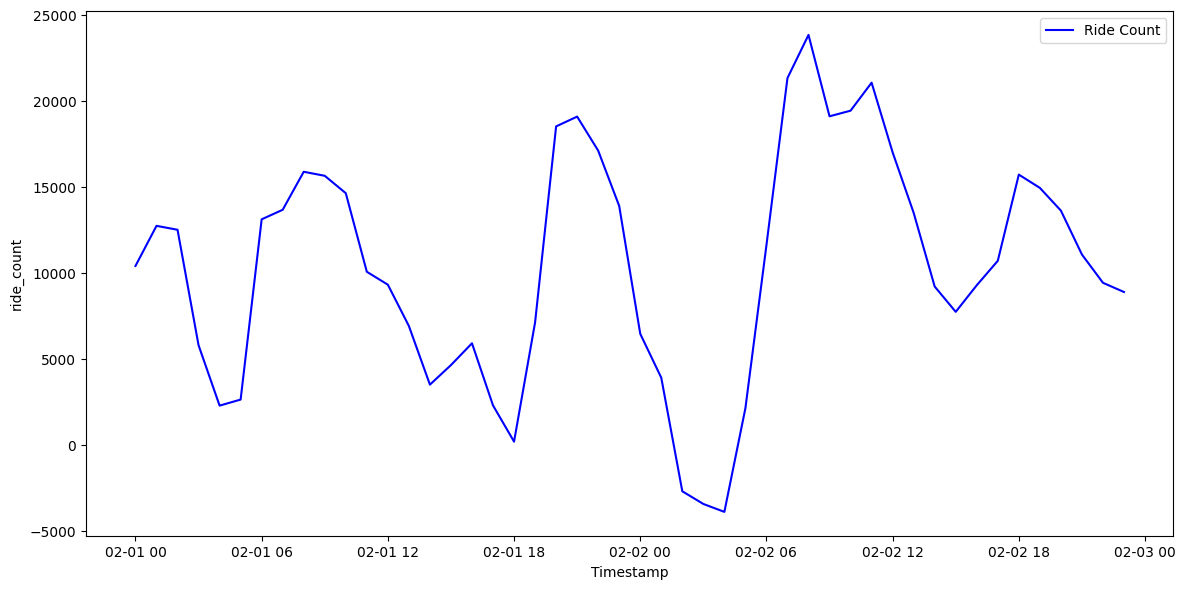

In [31]:
# Plot time series
plt.figure(figsize=(12, 6))
plt.plot(df[timestamps_col], df[f"{time_series_col}_synthetic"], "b-", label="Ride Count")

# Set labels
plt.xlabel("Timestamp")
plt.ylabel(time_series_col)

plt.tight_layout()
plt.legend()

## Now, let's do Forecasting

In [32]:
history_length = time_series_length - forecast_length

In [33]:
df_original = pd.read_csv(SYNTHEFY_DATASETS_BASE / Path("nycfhv") / Path("nycfhv_data_window.csv"))
df_original = df_original.drop(columns=["Unnamed: 0",])
df_original

,date,hour,ride_count,date_hour,gas_price,tmpf
0,2019-02-01,0,23513,2019-02-01 00:00:00,2.358,14.0
1,2019-02-01,1,13638,2019-02-01 01:00:00,2.358,14.0
2,2019-02-01,2,8765,2019-02-01 02:00:00,2.358,14.0
3,2019-02-01,3,6668,2019-02-01 03:00:00,2.358,14.0
4,2019-02-01,4,7379,2019-02-01 04:00:00,2.358,14.0
...,...,...,...,...,...,...
115,2019-02-05,19,37401,2019-02-05 19:00:00,2.337,63.0
116,2019-02-05,20,36425,2019-02-05 20:00:00,2.337,64.0
117,2019-02-05,21,35019,2019-02-05 21:00:00,2.337,65.0
118,2019-02-05,22,32886,2019-02-05 22:00:00,2.337,64.0


In [34]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        120 non-null    object 
 1   hour        120 non-null    int64  
 2   ride_count  120 non-null    int64  
 3   date_hour   120 non-null    object 
 4   gas_price   120 non-null    float64
 5   tmpf        120 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 5.8+ KB


In [35]:
columns_to_check = ["gas_price",]
null_counts = df_original[columns_to_check].isnull().sum()
null_counts

gas_price    0
dtype: int64

In [36]:
df = df_original.copy()

In [57]:
df['gas_price'] = 12.0

In [58]:
# Fill Null Values
df = df.fillna(method='ffill')

In [59]:
# make just one window
df = df[:time_series_length]

In [60]:
json_data_for_stream = df.to_json()

In [61]:
stream_synthesis_response = client.post(
    "/api/forecast/nycfhv/stream", json=json.loads(json_data_for_stream)
)

In [62]:
if stream_synthesis_response.status_code != 200:
    print(f"Error: {stream_synthesis_response.text}")
else:
    print(f"Success: Code={stream_synthesis_response.status_code}\n")

Success: Code=200



In [63]:
dynamic_time_series_data = DynamicTimeSeriesData(
    **stream_synthesis_response.json()
)

In [64]:
df_response = pd.read_json(json.dumps(stream_synthesis_response.json()))
df_response.info(); df_response

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ride_count_synthetic  48 non-null     float64
 1   date_hour             48 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


,ride_count_synthetic,date_hour
0,33633.000000,2019-02-01T12:00:00
1,34550.000000,2019-02-01T13:00:00
2,37430.000000,2019-02-01T14:00:00
3,39283.000000,2019-02-01T15:00:00
4,42599.000000,2019-02-01T16:00:00
5,50123.000000,2019-02-01T17:00:00
6,56710.000000,2019-02-01T18:00:00
7,59783.000000,2019-02-01T19:00:00
8,55238.000000,2019-02-01T20:00:00
9,51686.000000,2019-02-01T21:00:00


In [65]:
df_response["date_hour"] = pd.to_datetime(df_response["date_hour"], errors='coerce')
df["date_hour"] = pd.to_datetime(df["date_hour"], errors='coerce')
df_original["date_hour"] = pd.to_datetime(df_original["date_hour"], errors='coerce')

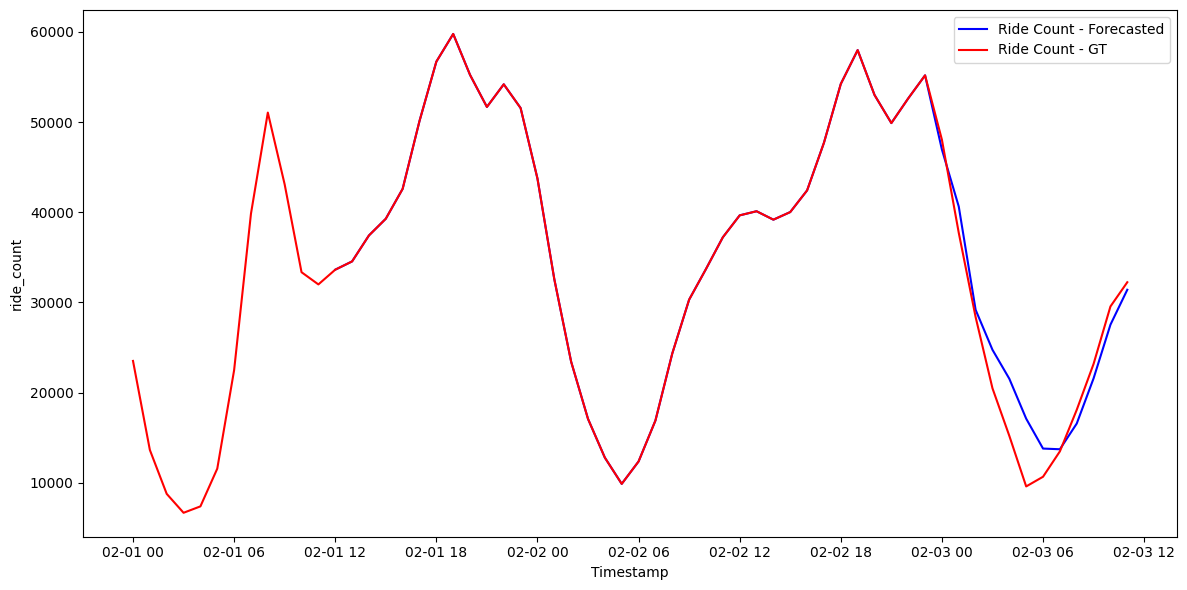

In [66]:
# Plot time series
plt.figure(figsize=(12, 6))
# plt.plot(df_response[timestamps_col][-history_length:], df_response[f"{time_series_col}_synthetic"][-history_length:], "b-", label="Ride Count - Forecasted")
plt.plot(df_response[timestamps_col], df_response[f"{time_series_col}_synthetic"], "b-", label="Ride Count - Forecasted")
plt.plot(df_original[timestamps_col][:time_series_length+forecast_length], df_original[f"{time_series_col}"][:time_series_length+forecast_length], "r-", label="Ride Count - GT")

# Set labels
plt.xlabel("Timestamp")
plt.ylabel(time_series_col)

plt.tight_layout()
plt.legend()

Performance doesn't seem to change regardless of how I set gas prices

Let's try a "warm Feb" with a temp of 60F

In [78]:
df = df_original.copy()

In [79]:
df['tmpf'] = 10.0

In [80]:
# Fill Null Values
df = df.fillna(method='ffill')

In [81]:
# make just one window
df = df[:time_series_length]

In [82]:
json_data_for_stream = df.to_json()

In [83]:
stream_synthesis_response = client.post(
    "/api/forecast/nycfhv/stream", json=json.loads(json_data_for_stream)
)

In [84]:
if stream_synthesis_response.status_code != 200:
    print(f"Error: {stream_synthesis_response.text}")
else:
    print(f"Success: Code={stream_synthesis_response.status_code}\n")

Success: Code=200



In [85]:
dynamic_time_series_data = DynamicTimeSeriesData(
    **stream_synthesis_response.json()
)

In [86]:
df_response = pd.read_json(json.dumps(stream_synthesis_response.json()))
df_response.info(); df_response

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ride_count_synthetic  48 non-null     float64
 1   date_hour             48 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


,ride_count_synthetic,date_hour
0,33633.000000,2019-02-01T12:00:00
1,34550.000000,2019-02-01T13:00:00
2,37430.000000,2019-02-01T14:00:00
3,39283.000000,2019-02-01T15:00:00
4,42599.000000,2019-02-01T16:00:00
5,50123.000000,2019-02-01T17:00:00
6,56710.000000,2019-02-01T18:00:00
7,59783.000000,2019-02-01T19:00:00
8,55238.000000,2019-02-01T20:00:00
9,51686.000000,2019-02-01T21:00:00


In [87]:
df_response["date_hour"] = pd.to_datetime(df_response["date_hour"], errors='coerce')
df["date_hour"] = pd.to_datetime(df["date_hour"], errors='coerce')
df_original["date_hour"] = pd.to_datetime(df_original["date_hour"], errors='coerce')

Text(0.5, 1.0, 'tmpf=10.0')

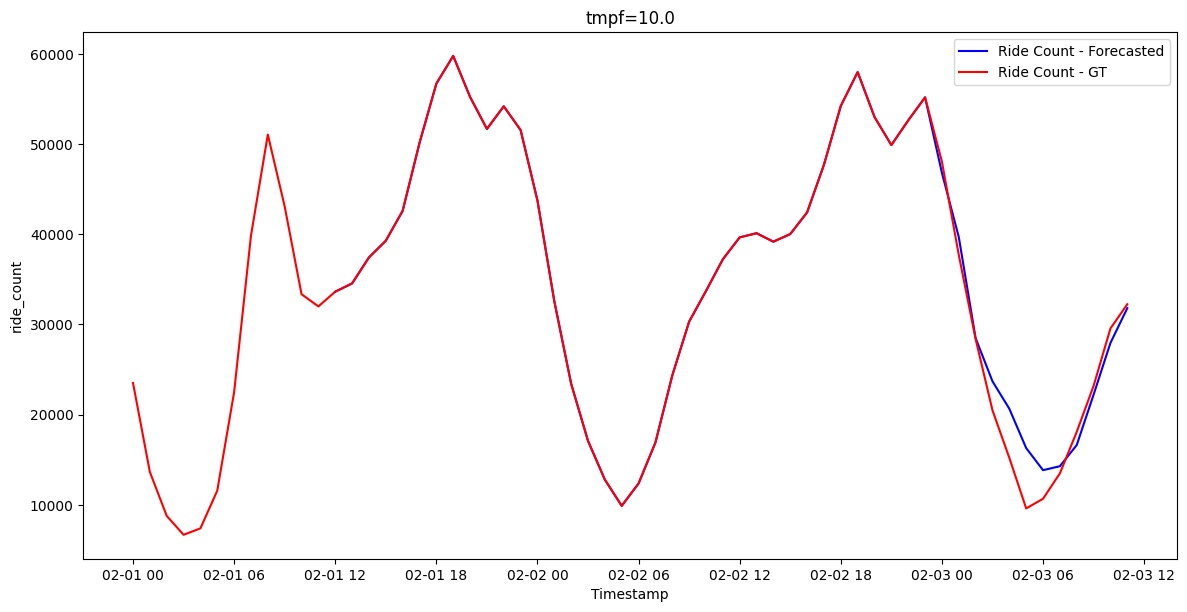

In [90]:
# Plot time series
plt.figure(figsize=(12, 6))
# plt.plot(df_response[timestamps_col][-history_length:], df_response[f"{time_series_col}_synthetic"][-history_length:], "b-", label="Ride Count - Forecasted")
plt.plot(df_response[timestamps_col], df_response[f"{time_series_col}_synthetic"], "b-", label="Ride Count - Forecasted")
plt.plot(df_original[timestamps_col][:time_series_length+forecast_length], df_original[f"{time_series_col}"][:time_series_length+forecast_length], "r-", label="Ride Count - GT")

# Set labels
plt.xlabel("Timestamp")
plt.ylabel(time_series_col)

plt.tight_layout()
plt.legend()

plt.title(f"tmpf={df['tmpf'][0]}")